In [2]:
#import sys
#sys.path = ['', '/Users/panda/miniconda2/lib/python27.zip',
#            '/Users/panda/miniconda2/lib/python2.7', '/Users/panda/miniconda2/lib/python2.7/plat-darwin', 
#            '/Users/panda/miniconda2/lib/python2.7/plat-mac', 
#            '/Users/panda/miniconda2/lib/python2.7/plat-mac/lib-scriptpackages', 
#            '/Users/panda/miniconda2/lib/python2.7/lib-tk', '/Users/panda/miniconda2/lib/python2.7/lib-old', 
#            '/Users/panda/miniconda2/lib/python2.7/lib-dynload', '/Users/panda/miniconda2/lib/python2.7/site-packages', 
#            '/Users/panda/miniconda2/lib/python2.7/site-packages/setuptools-19.6.2-py2.7.egg']

import seaborn as sns
import json
import pandas as pd
import numpy as np
from pandas.io import data
from pandas import Series, DataFrame
import nltk
import matplotlib.pyplot as plt
import math
import datetime
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
import sklearn.svm as svm
import sklearn.cross_validation as cross_validation
import sklearn.cluster as cluster
from sklearn.ensemble import AdaBoostClassifier
import sklearn.datasets as sk_data
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import sklearn.utils as utils

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns

import numpy as np


from scipy.spatial.distance import pdist, squareform
    
import gmplot
import collections
%matplotlib inline

## Class Station
This is the class to aggregate data. Latter we will use its location information to draw our results on map

In [3]:
'''
Cluster is based on each station's information, so this class is the abstract of station.

'''
class Station(object):
    
    # @station_id int
    # Use an integer number to initilize an station instance
    def __init__(self, station_id):
        self.station_id = station_id
        self.features = ['TEMP', 'DEWP', 'SLP', 'STP',
                         'VISIB','WDSP','MXSPD',
                         'GUST','MAX','MIN','SNDP','FOG',
                        'RAIN','SNOW','HAIL','THUNDER','TORNADO']
        
        self.missingValue = [9999.9, 9999.9, 9999.9, 9999.9,
                            999.9, 999.9, 999.9,999.9,
                             9999.9, 9999.9,999.9,
                            -1,-1,-1,-1,-1,-1]
        
        self.META = {}
        self.data = {}
        self.location = [0.0,0.0]
        
        for x in xrange(1,13,1):
            self.META[x] = {}
            self.data[x] = {}
            for name in self.features:
            
                self.META[x][name] = 0
                self.data[x][name] = 0
    
        
    
    # @month int
    # @data dict, must include all the fields that list in self.features
    # This method will filt all the default or missing value
    def inputData(self, month, data):
        
        for i in xrange(len(self.features)):
            name = self.features[i]
            
            rs = data.get(name, None)
            
            if rs != None and rs != self.missingValue[i] :
                self.data[month][name] += rs
                self.META[month][name] += 1
    
    # @month int
    # return the summary for each month. This is an inner function
    def summaryByMonth(self, month):
        exp = ['FOG','RAIN','SNOW','HAIL','THUNDER','TORNADO']
        result = []
        for kind in self.features:
            
            if kind in exp:
                result.append(self.data[month][kind])
            else:
                v = 0.0
                if self.META[month][kind] != 0:
                    v = (self.data[month][kind]+0.0) / (self.META[month][kind])
                result.append(v)
        return result
                    
    
    # For each station, this method return the summary.
    # This method return the feature vector for analyzing
    def summaryFeatureVector(self):
        rs = []
        for x in xrange(1,13,1):
            rs.extend(self.summaryByMonth(x))
        return rs
    
    # This method return method dictinary
    def summaryByDict(self):
        rs = {}
        for x in xrange(1,13,1):
            rs[x] = self.summaryByMonth(x)
        return rs



### Other helper functions


In [4]:

# Some of the data may contains one bit flag like '*,A,I' and so on
# This method will pop this value if it contains one bit tag
def extractNumber(s):
    last = s[-1]
    l = len(s)
    if ord(last) >= ord('0') and ord(last) <= ord('9'):
        return s
    else:
        return s[0:l-1]

# 6 special weather are represented by 6-bits string in the raw data
# Here I extract them and write the value to its coresponded field  
def extractSpecialWeather(d, s):
    w = ['FOG', 'RAIN', 'SNOW', 'HAIL', 'THUNDER', 'TORNADO']
    if len(s) != 6 :
        print 'alert! not well-formed data'
    
    for i in xrange(6):
        if s[i] == '1':
            d[w[i]] = 1
        else:
            d[w[i]] = 0
    return d
    
# Input the joined data file path
# Read line by line and build a dict with all stations
def buildStationDict(filepath):
    rs = {}
    f = open(filepath)
    names = ['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 
             'GUST', 'MAX', 'MIN', 'SNDP', 'FOG', 'RAIN', 'SNOW', 'HAIL', 
             'THUNDER', 'TORNADO']
    for each in f:
        data = each.strip().split(',')
        station_id = int(data[0])
        month = data[2][4:6]
        month = int(month)
        fdict = {}
        i = 0
        for x in xrange(3, 17, 2):
            fdict[names[i]] = float(data[x])
            i+=1
        fdict['GUST'] = float(data[16])
        
        maxV = extractNumber(data[17])
        minV = extractNumber(data[18])
        
        
        fdict['MAX'] = float(maxV)
        fdict['MIN'] = float(minV)
        fdict['SNDP'] = float(data[20])
        fdict = extractSpecialWeather(fdict, data[21])
        
        if rs.get(station_id) == None:
            p = Station(station_id)
            rs[station_id] = p
        p = rs[station_id]
        p.location = [data[-2],data[-1]]
        p.inputData(month, fdict)
    return rs
        
        

        
# Convert raw data location format
# For the latitude and logitude, E,N will be positive while W,S will be negative
def getLocation(loc):
    rs = [0,0]
    
    la = loc[0]
    lo = loc[1]
    
    end_la = la[-1]
    end_lo = lo[-1]
    
    l1 = len(la)
    l2 = len(lo)
    
    la = la[0:l1-1]
    lo = lo[0: l2-1]
    
    if end_la == 'N':
        rs[0] = float(la) / 100.0
    else:
        rs[0] = float(la) / -100.0
    
    if end_lo == 'E':
        rs[1] = float(lo) / 100.0
    else:
        rs[1] = float(lo) / -100.0
    return rs    
    
# @data pandas.DataFrame  Must contains 3 feilds, 'latitude','longitude','label'
# @filepath str specify where you want to store the result
# @colors, If you have more than 6 labels, you should specify your own color list
def showOnMap(data, filepath,colors = []):
    gmap = gmplot.GoogleMapPlotter(36.161517,-115.164011,16)

    la = list(data['latitude'])
    lo = list(data['longitude'])
    label = list(data['label'])
    
    if len(colors) == 0:
        colors = ['#ff0000','#00ff00','#0000ff','#ffff00','#ff00ff','#00ffff']
    draw_la = collections.defaultdict(list)
    draw_lo = collections.defaultdict(list)

    kind = len(colors)
    for i in range(len(label)):
        try:
            color = colors[int(label[i]) % kind]
        
            draw_la[color].append(la[i])
            draw_lo[color].append(lo[i])
        except:
            print i
            print label[i]

    for each in draw_la.keys():
        gmap.scatter(draw_la[each], draw_lo[each], each, size=10000, marker=False)
    gmap.draw(filepath)   

    
# @data pandas.DataFrame
# @n_clusters  How many clusters you want
# @plot_graph Only to be True if you want to plot the graph, especially when there are only 2 labels
def GMMCluster(data, n_clusters = 3, plot_graph = False):
    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    print n_clusters
    gmm = mixture.GMM(n_components=n_clusters, covariance_type='diag')
    gmm.fit(data)
    y_pred = gmm.predict(data)
    
    if plot_graph:   
        plt.scatter(data[:, 0], data[:, 1], s=10,color=colors[y_pred].tolist(), alpha=0.8)
        plt.show()
    return y_pred

'''
data: ndarray. Data matrix
n_clusters: int. How many clusters you want to have.
detail: bool. Whether to out put some detail information
plot_graph: bool. Whether to plot heat graph to compare unsorted and sorted label. 

return type (labels, centers)
'''
def kMeansCluster(data,clusters = 10, detail = False,plot_graph = False):
    colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
    kmeans = KMeans(init='k-means++', n_clusters=clusters, n_init=10)
    kmeans.fit_predict(data)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    error = kmeans.inertia_
    
    if detail:
        print "The total error of the clustering is: ", error
        print '\nCluster labels'
        print labels
        print '\n Cluster Centroids'
        print centroids
        
    if plot_graph:
        
        plt.scatter(data[:, 0], data[:, 1], s=10,color=colors[labels].tolist(), alpha=0.8)
        plt.show()
        #idx = np.argsort(labels)
        #rX = X[idx,:]
        #fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,10))
        #sns.heatmap( rX,xticklabels=False, yticklabels=False, linewidths=0,cbar=True,ax = ax1)
        #sns.heatmap( X,xticklabels=False, yticklabels=False, linewidths=0,cbar=True,ax = ax2)
    return (labels, centroids)

'''
data: ndarry. Data matrix
begin: int. The beginning test number of cluster
end: int. The maximum number of clusters
'''
def estimateCluster(data, end = 11):
    error = np.zeros(end)
    error[0] = 0;
    for k in range(1,end):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(data)
        error[k] = kmeans.inertia_

    plt.plot(range(1,len(error)),error[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Error')


### Build the station dictionary

In [5]:
m = buildStationDict('data_with_location.csv')

### Convert station to feature vector

In [6]:
features = []
locations = []    

for station_id in m.keys():    
    station = m[station_id]
    locations.append( getLocation( station.location) )
    features.append(station.summaryFeatureVector())
    

data = np.array(features)


### K-Means 

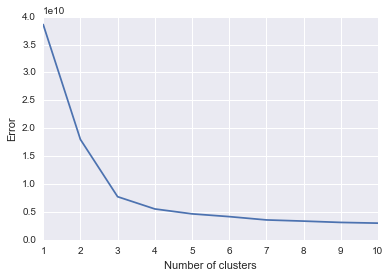

In [7]:
ec = estimateCluster(data, 11)

In [8]:
labels,centers = kMeansCluster(data,10)
print labels
print centers

[3 2 1 ..., 1 1 3]
[[  2.33052813e+01   1.73307565e+01   2.96857547e+02 ...,   4.85722573e-17
    1.73333333e-01  -3.90312782e-18]
 [  3.56709869e+01   2.67344263e+01   1.01045310e+03 ...,   6.11983339e-02
    6.79269465e-01   2.24287087e-03]
 [  3.52446213e+01   2.67089940e+01  -1.04591891e-11 ...,   3.52760736e-02
    6.34202454e-01   7.66871166e-03]
 ..., 
 [  2.59752071e+01   1.86527560e+01   1.93338421e+02 ...,   8.32667268e-17
    1.06666667e+00  -5.63785130e-18]
 [  4.65513429e+01   3.63502082e+01   9.83534230e+02 ...,   1.31428571e-01
    1.27428571e+00   5.71428571e-03]
 [  4.35016917e+01   3.68525676e+01   1.01900825e+03 ...,   7.85340314e-02
    5.65445026e-01   5.23560209e-03]]


In [9]:
las = []
los = []
label = []
i = 0
for each in locations:
    las.append(each[0])
    los.append(each[1])
    label.append(labels[i])
    i+=1

rs = {'latitude':las, 'longitude':los, 'label':label}

df = pd.DataFrame(rs)

print df.columns

colors = ['#000000','#0000FF','#8A2BE2',
          '#5F9EA0','#7FFF00','#FF7F50',
          '#DC143C', '#00FFFF','#006400',
         '#8B008B']

    

showOnMap(df, 'cluster.html',colors)

Index([u'label', u'latitude', u'longitude'], dtype='object')


### Do GMM cluster
Do GMM cluster and show it on the map

In [10]:
labels = GMMCluster(data, 15)

15


In [11]:
las = []
los = []
label = []
i = 0
for each in locations:
    las.append(each[0])
    los.append(each[1])
    label.append(labels[i])
    i+=1

rs = {'latitude':las, 'longitude':los, 'label':label}

df = pd.DataFrame(rs)

print df.columns

colors = ['#000000','#0000FF','#8A2BE2',
          '#5F9EA0','#7FFF00','#FF7F50',
          '#DC143C', '#00FFFF','#006400',
         '#8B008B', '#556B2F','#483D8B',
         '#9400D3','#FFD700','#FF4500']

    

showOnMap(df, 'GMM-cluster.html',colors)

Index([u'label', u'latitude', u'longitude'], dtype='object')


## Classification

- First part is the helper functions
- Prefix of missing value
- Use SVM to predict special weather
- Draw ROC curve to show our result
- Use Ramdom Forest to do classification

#### Helper Functions

In [12]:
import collections

# @weather_str 6-bits string. 
# @in_detail if True, return lables from 0 to 63. If False, return boolean labels
def getSpecialWeatherLabel(weather_str, in_detail = True):
    
    label = 0
    for x in range(6):
        weight = 1 << x
        v = int(weather_str[x])
        label += weight*v
    
    if in_detail:
        return label
    else:
        return label == 0
        

# For each row in the file, get its features and labels
# @filepath input data file path
# @return type: pandas.DataFrame
def extractClassificationTable(filepath, default_values = None, detail_label = True):
    f = open(filepath)
    
    fdict = collections.defaultdict(list)
    names = ['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 
             'GUST', 'MAX', 'MIN', 'SNDP', 'FOG', 'RAIN', 'SNOW', 'HAIL', 
             'THUNDER', 'TORNADO']
    for each in f:
        data = each.strip().split(',')
        #get month
        month = data[2][4:6]
        month = int(month)
        
        fdict['MONTH'].append(month)
        
        i = 0
        for x in xrange(3, 17, 2):
            fdict[names[i]].append(float(data[x]))
            i+=1
        fdict['GUST'].append(float(data[16]))
        
        maxV = extractNumber(data[17])
        minV = extractNumber(data[18])
        
        
        fdict['MAX'].append(float(maxV))
        fdict['MIN'].append(float(minV))
        fdict['SNDP'].append(float(data[20]))
        fdict['LABEL'].append(getSpecialWeatherLabel(data[21], detail_label))
        
        lati, logi = getLocation([data[-2],data[-1]])
        fdict['LAT'].append(lati)
        fdict['LOG'].append(logi)
    
    frame = pd.DataFrame(fdict)
    
    return frame
        

def extractClassificationTableWithFilter(filepath, default_values, detail_label = True):
    f = open(filepath)
    d = [999.9, 9999.9, -1]
    fdict = collections.defaultdict(list)
    names = ['TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 
             'GUST', 'MAX', 'MIN', 'SNDP', 'FOG', 'RAIN', 'SNOW', 'HAIL', 
             'THUNDER', 'TORNADO']
    for each in f:
        data = each.strip().split(',')
        #get month
        month = data[2][4:6]
        month = int(month)
        
        fdict['MONTH'].append(month)
        
        i = 0
        for x in xrange(3, 17, 2):
            v = float(data[x])
            
            if v in d:
                avg_value = default_values.get(names[i], 0.0)
                fdict[names[i]].append(avg_value)
            else:
                fdict[names[i]].append(v)
            i+=1
            
        rest = []
        #fdict['GUST'].append(float(data[16]))
        rest.append(float(data[16]))
        
        maxV = extractNumber(data[17])
        minV = extractNumber(data[18])
        rest.append(maxV)
        rest.append(minV)
        rest.append(float(data[20]))
        
        rest_names = ['GUST', 'MAX', 'MIN', 'SNDP']
        for name, v in zip(rest_names, rest):
            if v in d:
                avg_value = default_values.get(name, 0.0)
                fdict[name].append(avg_value)

            else:
                fdict[name].append(v)
                
        
        #fdict['MAX'].append(float(maxV))
        #fdict['MIN'].append(float(minV))
        #fdict['SNDP'].append(float(data[20]))
        fdict['LABEL'].append(getSpecialWeatherLabel(data[21], detail_label))
        
        lati, logi = getLocation([data[-2],data[-1]])
        fdict['LAT'].append(lati)
        fdict['LOG'].append(logi)
    
    frame = pd.DataFrame(fdict)
    
    return frame    

    
    
    
    

In [13]:
# This Cell is used for take sample

import random

f = open('data_with_location.csv')
fin = open('data_narrow.csv','w')

for each in f:
    i = random.random()
    if i < 0.01:
        fin.write(each)

f.close()
fin.close()

### Prefix missing values

In [31]:
classify_dataframe = extractClassificationTable('data_narrow.csv', detail_label = True)

In [32]:
def mean_columns(name,dataframe):
    sum_values=0.0
    column_len = len(dataframe[name])
    count=0
    mean = 0.0
    d = [999.9, 9999.9, -1]
    for index, row in dataframe.iterrows():
        value =  row[name]
        if value not in d:
            mean += value
            count+=1
    if count != 0:
        sum_values = ((mean+0.0) / count)
    else:
        sum_values=0
    return sum_values

In [33]:
sum_values= []
names = ['SLP', 'DEWP', 'GUST', 'STP', 'WDSP', 'MXSPD', 
             'TEMP', 'MAX', 'MIN', 'SNDP']
for name in names:
    value = mean_columns(name,classify_dataframe)
    sum_values.append(value)
    

In [34]:
d = {}
for n, v in zip(names, sum_values):
    d[n] = v

classify_dataframe = extractClassificationTableWithFilter('data_narrow.csv', d, True)


In [35]:
y = classify_dataframe['LABEL']
X = classify_dataframe[['DEWP', 'GUST', 'MAX', 'MIN', 'MXSPD', 'SLP', 'SNDP', 'STP','TEMP', 'WDSP']]
print X.shape
print y.head(10)

(23566, 10)
0    4
1    4
2    4
3    0
4    0
5    0
6    0
7    0
8    0
9    2
Name: LABEL, dtype: int64


#### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier


X, y = utils.shuffle(X, y, random_state=1)

train_set_size = 5000
X_train = X[:train_set_size]  # selects first 10000 rows (examples) for train set
y_train = y[:train_set_size]
X_test = X[train_set_size:]   # selects from row 10000 until the last one for test set
y_test = y[train_set_size:]
print(X_train.shape), y_train.shape
print(X_test.shape), y_test.shape

(5000, 10) (5000L,)
(18566, 10) (18566L,)


In [37]:
rf = RandomForestClassifier(n_estimators=50,oob_score=True)#number of trees in the forest is 50 , '100' gives just little more accuracy than '50'
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [38]:
pred=rf.predict(X_test)
rf.score(X_test,y_test)#mean accuracy 0f the given test data and labels


0.65867715178282882

### SVM

In [40]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

svc = svm.SVC(kernel='linear', max_iter=10000)
svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)
print "Accuracy of SVM test set:", svc.score(X_test, y_test)

Accuracy of SVM test set: 0.0719594958526


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

classifier = OneVsRestClassifier(svc)

y_score = classifier.fit(X_train, y_train).decision_function(X_test)

print y_score.shape


(11783L, 25L)


### Regression
+ Mutiple Linear Regression
+ Linear Rgression
+ Logic Regression based on binary label
+ Gradient Boosting Regression Tree

In [43]:
import pandas as pd
import statsmodels.api as sm


X = sm.add_constant(X)
model1 = sm.OLS(y, X.astype(float)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  LABEL   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     174.0
Date:                Sat, 23 Apr 2016   Prob (F-statistic):               0.00
Time:                        14:59:57   Log-Likelihood:                -66520.
No. Observations:               23566   AIC:                         1.331e+05
Df Residuals:                   23555   BIC:                         1.331e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         40.4819      3.825     10.582      0.000        32.984    47.980
DEWP           0.0849      0.003     30.638      0.000         0.079     0.090
GUST           0.0495      0.007      7.208      0.000         0.036     0.063
MAX        -6.881e-05   8.69e-05     -0.792      0.428        -0.000     0.000
MIN         7.013e-05   8.07e-05      0.869      0.385      -8.8e-05     0.000
MXSPD          0.1503      0.009     17.384      0.000         0.133     0.167
SLP           -0.0388      0.004    -10.350      0.000        -0.046    -0.031
SNDP           0.0179      0.009      1.927      0.054        -0.000     0.036
STP           -0.0014      0.001     -2.317      0.020        -0.003    -0.000
TEMP          -0.0602      0.003    -23.714      0.000        -0.065    -0.055
WDSP          -0.2382      0.012    -20.077      0.000        -0.261    -0.215
==============================================================================
Omnibus:                    14332.041   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114780.107
Skew:                           2.954   Prob(JB):                         0.00
Kurtosis:                      12.054   Cond. No.                     2.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
import statsmodels.api as sm

print X.shape
print type(y)
print y.shape
#mod = smf.ols(formula='Average_Score ~ Location + Sleep + Rooms + Service + Value + Clean', data=df)
#res = mod.fit()
#print(res.summary())
#print df
model = sm.OLS(y, X.astype(float))
results = model.fit()
print results.summary()
print "Confidence Intervals:", results.conf_int()
print "Parameters:", results.params

(23566, 11)
<class 'pandas.core.series.Series'>
(23566L,)
                            OLS Regression Results                            
Dep. Variable:                  LABEL   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     174.0
Date:                Sat, 23 Apr 2016   Prob (F-statistic):               0.00
Time:                        15:00:03   Log-Likelihood:                -66520.
No. Observations:               23566   AIC:                         1.331e+05
Df Residuals:                   23555   BIC:                         1.331e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------

In [45]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error


params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}
gbrt = ensemble.GradientBoostingRegressor(**params)
gbrt = gbrt.fit(X_train,y_train)

mse = mean_squared_error(y_test, gbrt.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 15.2833


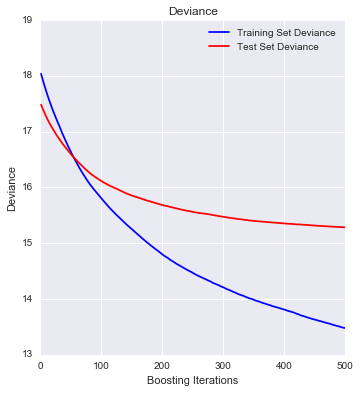

In [46]:
clf = gbrt

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')